# Import Necessary Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nasa-nearest-earth-objects-1910-2024/nearest-earth-objects(1910-2024).csv


# Load the Data

In [2]:
df = pd.read_csv('/kaggle/input/nasa-nearest-earth-objects-1910-2024/nearest-earth-objects(1910-2024).csv')

In [3]:
df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [4]:
df.shape

(338199, 9)

In [5]:
df.dtypes

neo_id                      int64
name                       object
absolute_magnitude        float64
estimated_diameter_min    float64
estimated_diameter_max    float64
orbiting_body              object
relative_velocity         float64
miss_distance             float64
is_hazardous                 bool
dtype: object

In [6]:
df.describe()

,neo_id,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
count,3.381990e+05,338171.000000,338171.000000,338171.000000,338199.000000,3.381990e+05
mean,1.759939e+07,22.932525,0.157812,0.352878,51060.662908,4.153535e+07
std,2.287225e+07,2.911216,0.313885,0.701869,26399.238435,2.077399e+07
min,2.000433e+06,9.250000,0.000511,0.001143,203.346433,6.745533e+03
25%,3.373980e+06,20.740000,0.025384,0.056760,30712.031471,2.494540e+07
50%,3.742127e+06,22.800000,0.073207,0.163697,47560.465474,4.332674e+07
75%,5.405374e+07,25.100000,0.189041,0.422708,66673.820614,5.933961e+07
max,5.446281e+07,33.580000,37.545248,83.953727,291781.106613,7.479865e+07


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


## Check If Exist Null Value

<Axes: >

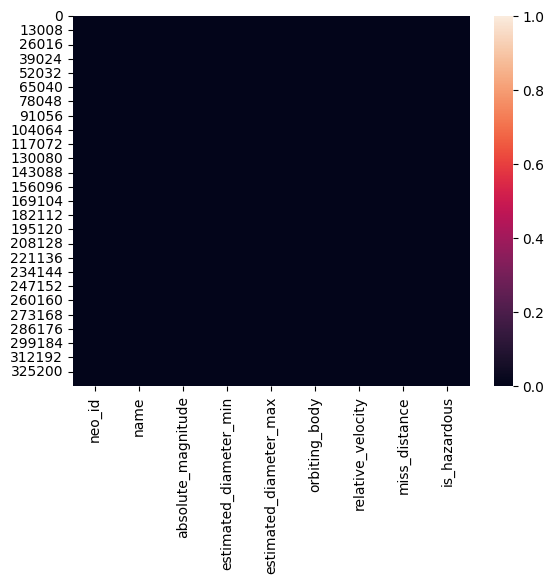

In [8]:
sns.heatmap(df.isnull())

In [9]:
df.isnull().sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

### Handling Missing Value

In [10]:
df.fillna({
    'absolute_magnitude'     : df['absolute_magnitude'].mean(),
    'estimated_diameter_min' : df['estimated_diameter_min'].mean(),
    'estimated_diameter_max' : df['estimated_diameter_max'].mean()
        },inplace = True) 

In [11]:
df.isnull().sum()

neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    0
orbiting_body             0
relative_velocity         0
miss_distance             0
is_hazardous              0
dtype: int64

<Axes: >

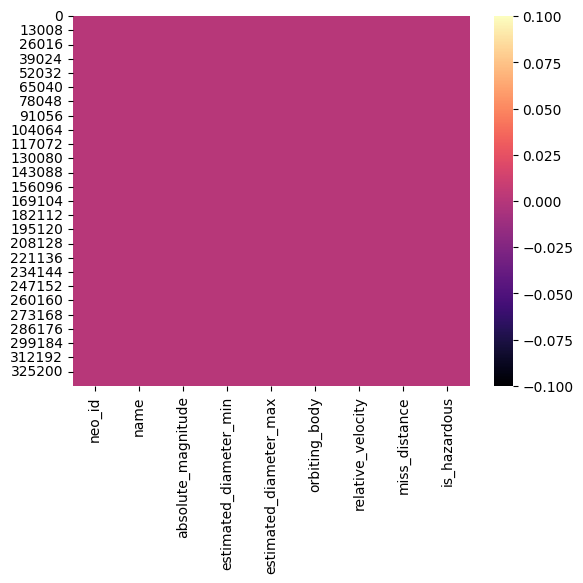

In [12]:
sns.heatmap(df.isnull(),cmap = 'magma')

## Check If Exist Duplicated Value

In [13]:
df.duplicated().sum()

0

In [14]:
df.columns

Index(['neo_id', 'name', 'absolute_magnitude', 'estimated_diameter_min',
       'estimated_diameter_max', 'orbiting_body', 'relative_velocity',
       'miss_distance', 'is_hazardous'],
      dtype='object')

In [15]:
df['orbiting_body'].value_counts()

orbiting_body
Earth    338199
Name: count, dtype: int64

In [16]:
df['name'].value_counts()

name
277810 (2006 FV35)               211
469219 Kamo`oalewa (2016 HO3)    197
(2014 OL339)                     192
(2017 FZ2)                       186
(2023 FW13)                      169
                                ... 
(2016 SE2)                         1
(2016 RY19)                        1
(2016 RT33)                        1
(2016 RZ33)                        1
(2024 NE)                          1
Name: count, Length: 33514, dtype: int64

# Exploratory Data Anlaysis (EDA)

* ## Hazardous vs. Non-Hazardous Objects

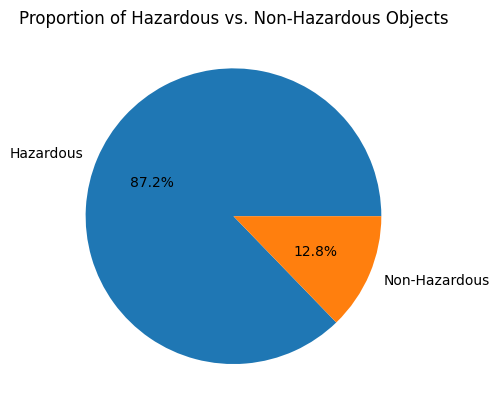

In [17]:
hazardous_counts = df['is_hazardous'].value_counts()

labels = ['Hazardous', 'Non-Hazardous']

plt.pie(hazardous_counts, labels=labels, autopct='%1.1f%%', radius=1)
plt.title('Proportion of Hazardous vs. Non-Hazardous Objects')
plt.show()

* ## Distribution of Object Sizes

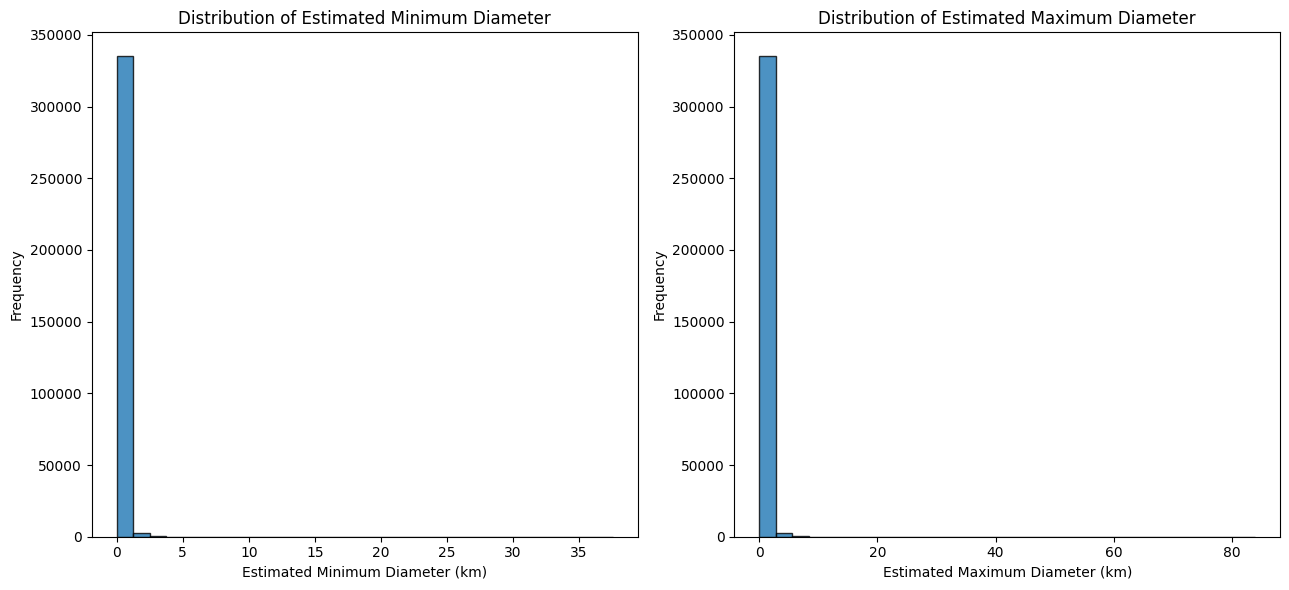

In [18]:
plt.figure(figsize=(13, 6))

plt.subplot(1, 2, 1)
plt.hist(df['estimated_diameter_min'] , bins=30, edgecolor='black', alpha=0.8)
plt.title('Distribution of Estimated Minimum Diameter')
plt.xlabel('Estimated Minimum Diameter (km)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['estimated_diameter_max'] , bins=30, edgecolor='black', alpha=0.8)
plt.title('Distribution of Estimated Maximum Diameter')
plt.xlabel('Estimated Maximum Diameter (km)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

* ## Scatter Plot of Relative Velocity vs Hazard Status

Text(0, 0.5, 'Relative Velocity (km/s)')

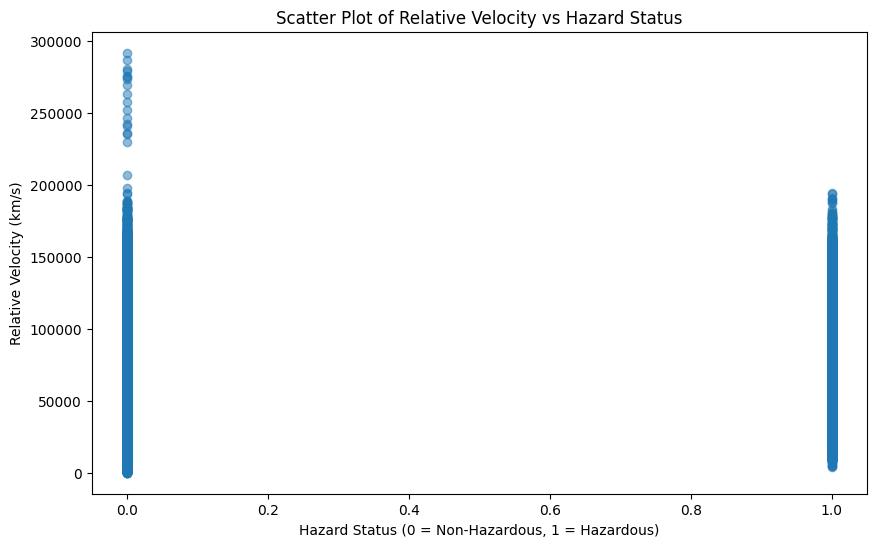

In [19]:
df['is_hazardous_numeric'] = df['is_hazardous'].replace({'True': 1, 'False': 0})

plt.figure(figsize=(10, 6))
plt.scatter(df['is_hazardous_numeric'], df['relative_velocity'], alpha=0.5)

plt.title('Scatter Plot of Relative Velocity vs Hazard Status')
plt.xlabel('Hazard Status (0 = Non-Hazardous, 1 = Hazardous)')
plt.ylabel('Relative Velocity (km/s)')

* ## Miss Distance vs. Object Size

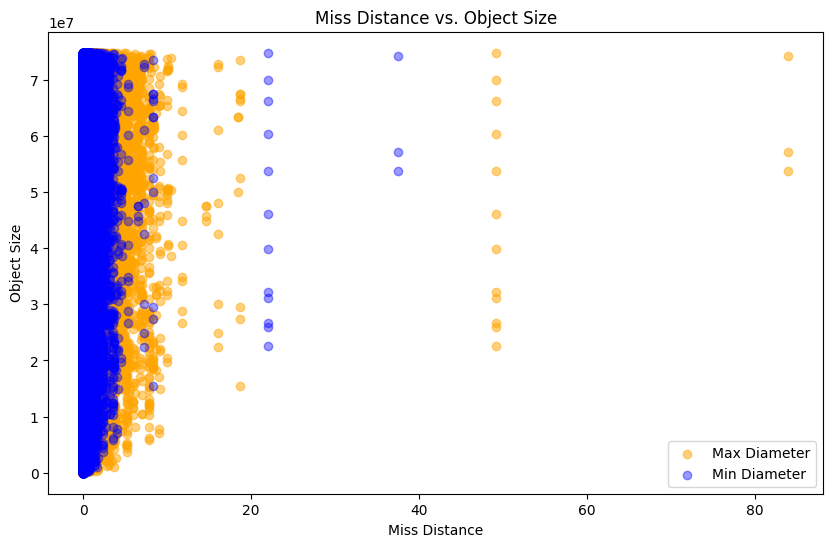

In [20]:
plt.figure(figsize = (10,6))
plt.scatter(df['estimated_diameter_max'], df['miss_distance'] ,
            color = 'orange', alpha = .5, label='Max Diameter')
plt.scatter(df['estimated_diameter_min'], df['miss_distance'] ,
            color = 'blue', alpha = .4, label='Min Diameter')
plt.title('Miss Distance vs. Object Size')
plt.xlabel('Miss Distance')
plt.ylabel('Object Size')
plt.legend()
plt.show()

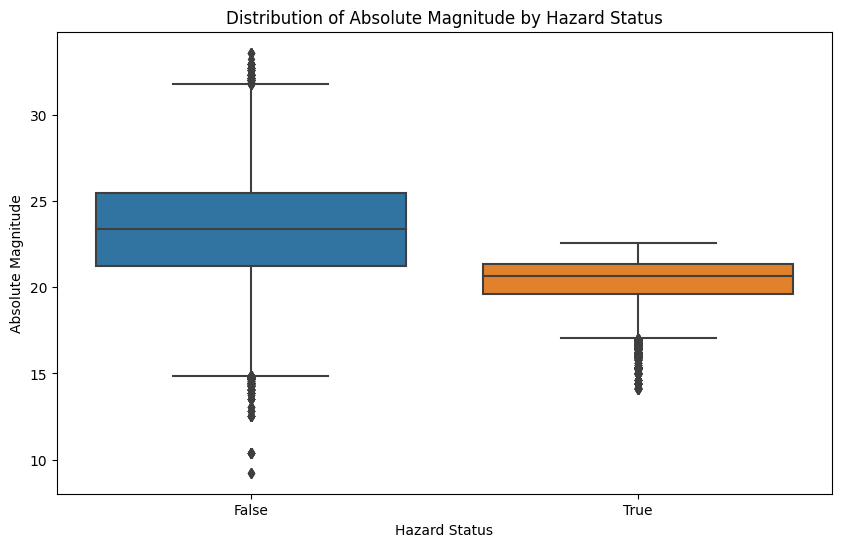

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_hazardous_numeric', y='absolute_magnitude', data=df)
plt.title('Distribution of Absolute Magnitude by Hazard Status')
plt.xlabel('Hazard Status')
plt.ylabel('Absolute Magnitude')
plt.show()

# Feature Selection

In [22]:
df.drop('neo_id', axis=1, inplace=True)
df.drop('orbiting_body', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)

# Check If Exist Outliers

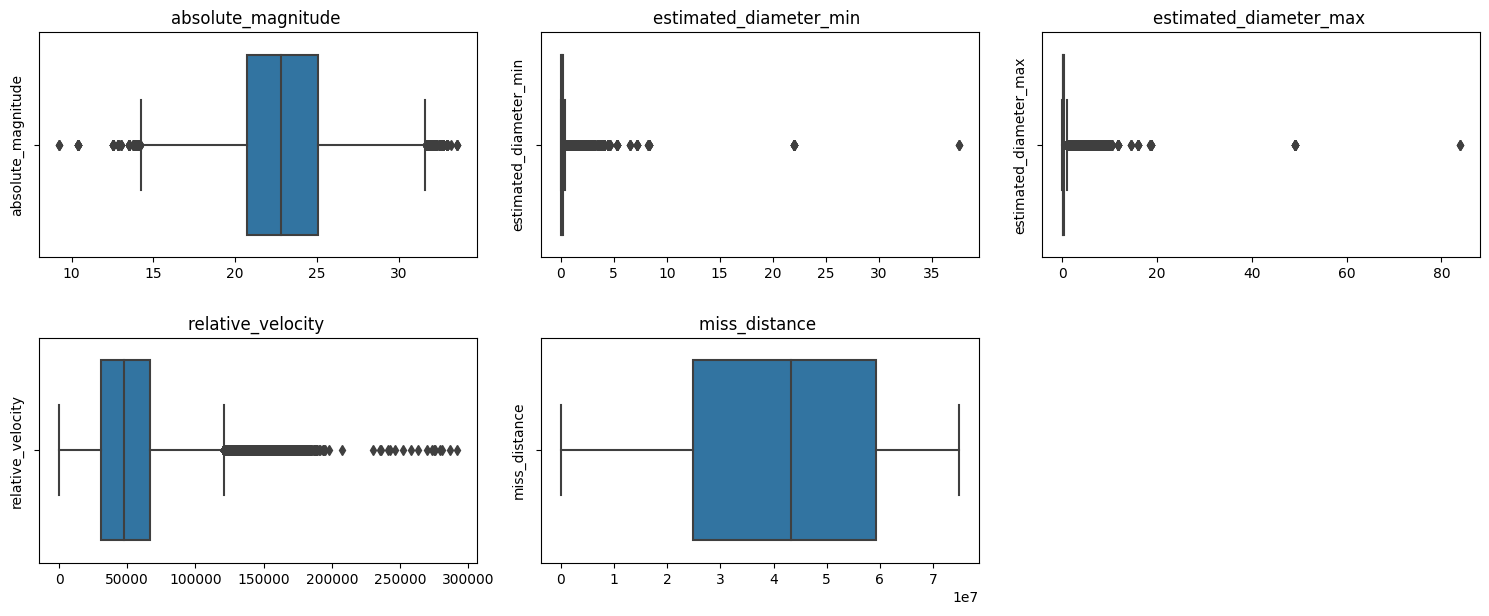

In [23]:
plt.figure(figsize=(15, 15))
for i, feature in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(data=df, x=feature)
    plt.title(f'{feature} ')
    plt.xlabel(' ')
    plt.ylabel(feature)
plt.tight_layout()

## Remove Outliers

In [24]:
def remove_outliers(feature):
    global df
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.65)
    iqr = q3 - q1

    upper_limit = q3 + (1.5 * iqr)
    lower_limit = q1 - (1.5 * iqr)

    df = df.loc[(df[feature] < upper_limit) & (df[feature] > lower_limit)]

In [25]:
features_list = ["absolute_magnitude", "estimated_diameter_min", "estimated_diameter_max", "relative_velocity"]

for feature in features_list:
    remove_outliers(feature)

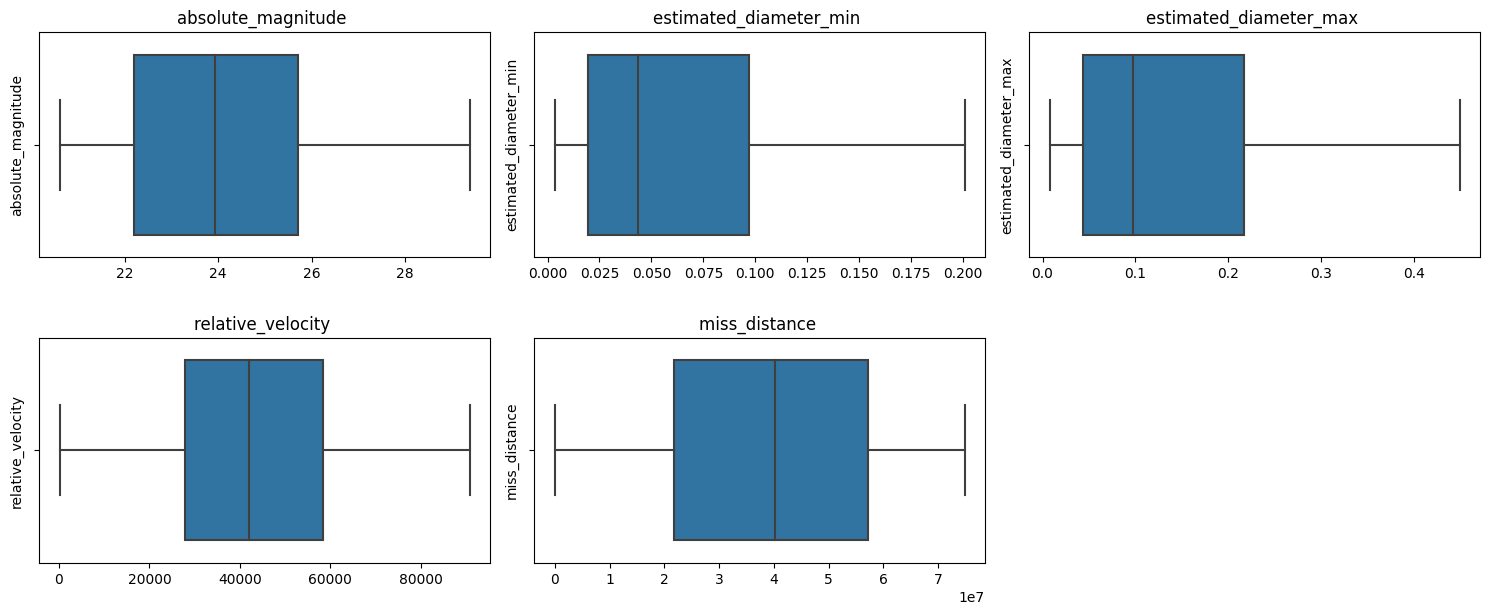

In [26]:
plt.figure(figsize=(15, 15))
for i, feature in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(data=df, x=feature)
    plt.title(f'{feature} ')
    plt.xlabel(' ')
    plt.ylabel(feature)
plt.tight_layout()

# checking if the data is balanced

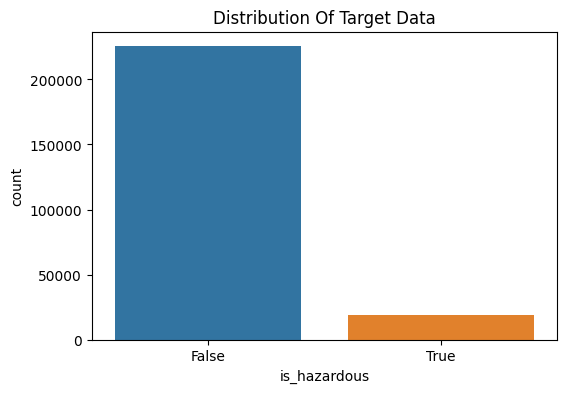

In [27]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['is_hazardous'])
plt.title("Distribution Of Target Data")
plt.show()

## Data Balancing using Smote 

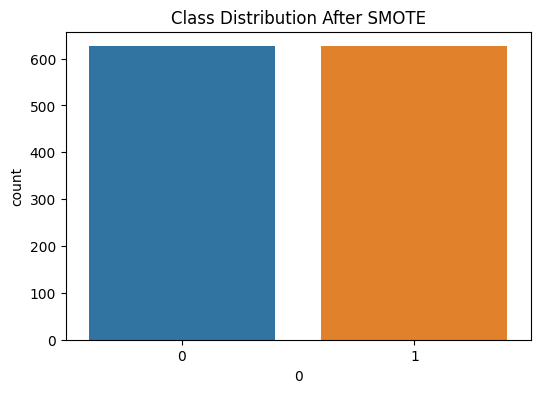

In [28]:
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, 
                           n_clusters_per_class=1, weights=[0.9, 0.1], random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_resampled_df = pd.DataFrame(X_resampled)
y_resampled_df = pd.DataFrame(y_resampled)

plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled_df[0])
plt.title("Class Distribution After SMOTE")
plt.show()

# Normalization

In [29]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(df)

print("Scaled Data:", scaled_data)

Scaled Data: [[-1.20828254  1.39134312  1.39134312 ...  1.33285611 -0.29007667
  -0.29007667]
 [-1.58809144  2.5727859   2.5727859  ... -0.41511648 -0.29007667
  -0.29007667]
 [-0.62930557  0.26437579  0.26437579 ...  1.13872184 -0.29007667
  -0.29007667]
 ...
 [-0.99105038  0.89114954  0.89114954 ...  0.68011169 -0.29007667
  -0.29007667]
 [-0.07950903 -0.345394   -0.345394   ... -1.61231377 -0.29007667
  -0.29007667]
 [-0.51304699  0.10631034  0.10631034 ... -1.52009923 -0.29007667
  -0.29007667]]


# Label Encoder Transformation

In [30]:
label_encoder = LabelEncoder()

In [31]:
df['is_hazardous'] = label_encoder.fit_transform(df['is_hazardous'])

# Correlation Heat map

In [32]:
corr_matrix = df.corr()

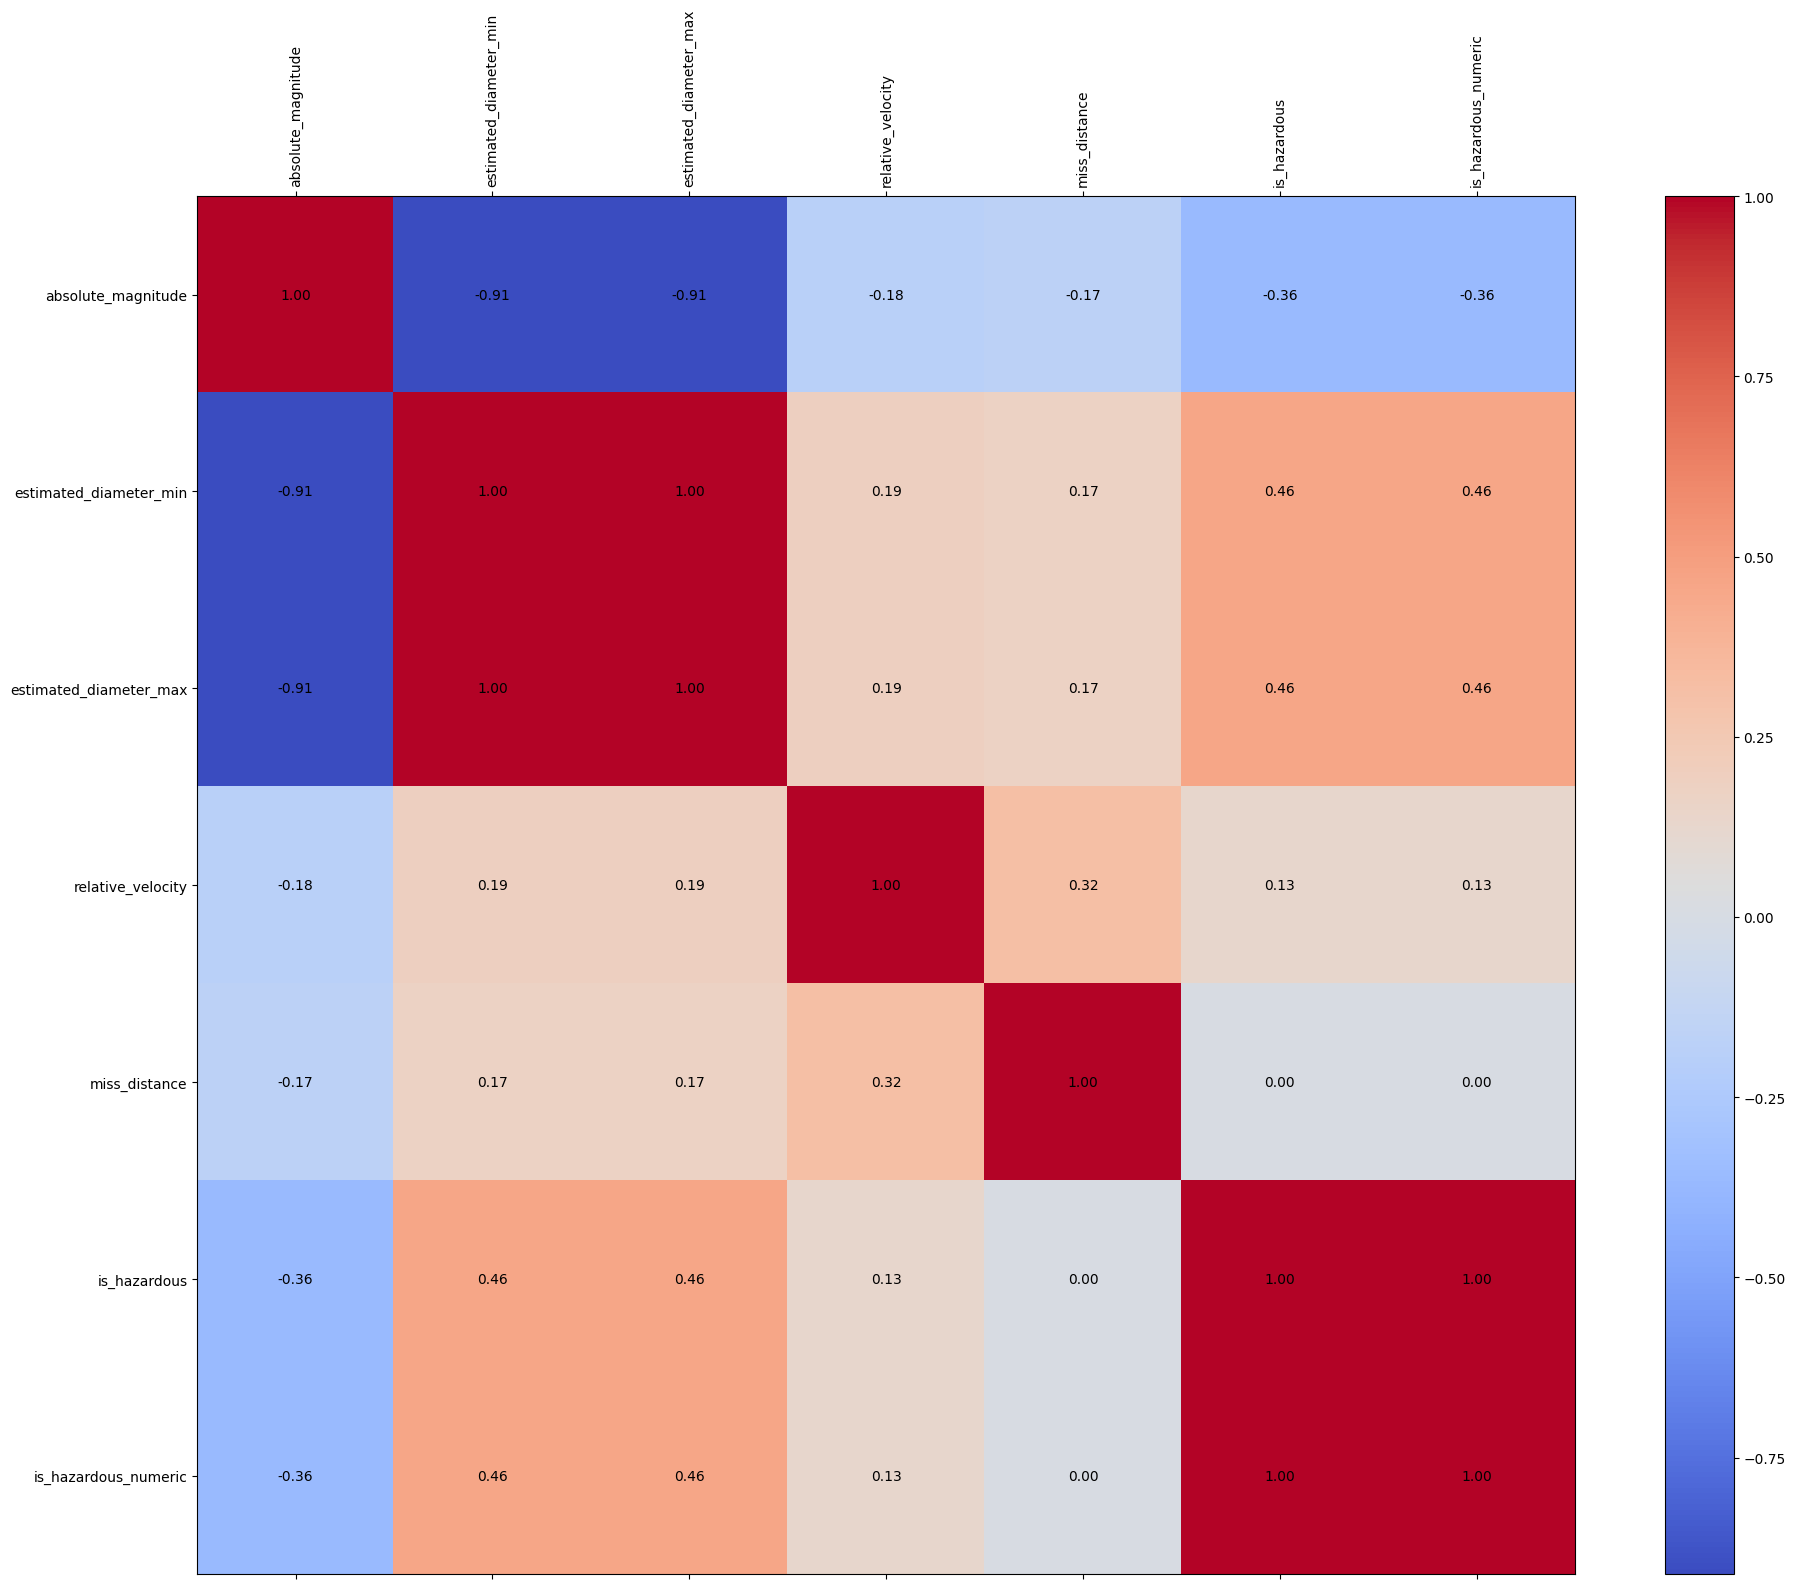

In [33]:
fig, ax = plt.subplots(figsize=(20, 16))

cax = ax.matshow(corr_matrix, cmap="coolwarm")

fig.colorbar(cax)

ticks = np.arange(0, len(corr_matrix.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)

for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.tight_layout()

plt.show()

# Train-Test-Split The Dataset

In [34]:
X = df.drop('is_hazardous',axis=1)
y = df['is_hazardous']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Model Building

In [36]:
def model_train_test(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
        
    train_accuracy = accuracy_score(y_train, pred_train)
    test_accuracy = accuracy_score(y_test, pred_test)
    print("Train Accuracy score = {:.2f}%".format(train_accuracy * 100))  
    print("Test Accuracy score = {:.2f}%".format(test_accuracy * 100))  
    
    print("\nClassification Report (Test Data):")
    print(classification_report(y_test, pred_test))
    
    precision = precision_score(y_test, pred_test, average='micro')
    recall = recall_score(y_test, pred_test, average='micro')
    f1 = f1_score(y_test, pred_test, average='micro')
    print("Precision (Test): {:.2f}".format(precision))
    print("Recall (Test): {:.2f}".format(recall))
    print("F1-score (Test): {:.2f}".format(f1))

## Random Forest Classifier

In [37]:
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=15)

In [38]:
rf_model = RandomForestClassifier(n_estimators=350,max_features=25,random_state=100)

In [39]:
model_train_test(rf_model,X_train, y_train, X_test, y_test)

Train Accuracy score = 100.00%
Test Accuracy score = 100.00%

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45172
           1       1.00      1.00      1.00      3724

    accuracy                           1.00     48896
   macro avg       1.00      1.00      1.00     48896
weighted avg       1.00      1.00      1.00     48896

Precision (Test): 1.00
Recall (Test): 1.00
F1-score (Test): 1.00
